# Data Analysis 

#### 1. libraries

In [1858]:
# relevant libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import matplotlib.dates as mdates
import warnings
from scipy.stats import skew, kurtosis, lognorm, kruskal, shapiro, norm, probplot
from scikit_posthocs import posthoc_dunn

warnings.filterwarnings("ignore")


#### 2. Data

In [1693]:
trajectory = gpd.read_file('../scratch/traj.geojson')
picks = gpd.read_file('../scratch/picks.geojson')

#### 3. Functions

In [1851]:
def categorize_location(df):
    """
    Categorizes the location based on the given conditions.

    Args:
        df (DataFrame): The input DataFrame containing the location information.

    Returns:
        DataFrame: The DataFrame with the 'location' column updated based on the conditions.
    """

    df['location'] = 'other'
    df['location'] = np.where(df['dense_urban_sidewalk'] == 1, 'dense_urban_sidewalk', df['location'])
    df['location'] = np.where(df['neighborhood_sidewalk'] == 1, 'neighborhood_sidewalk', df['location'])
    df['location'] = np.where(df['park'] == 1, 'park', df['location'])
    df['location'] = np.where(df['country_side'] == 1, 'country_side', df['location'])
    df = df[df['location'] != 'other']
    return df

def categorize_picks(picks):
    """
    Categorizes the picks based on different types of waste.

    Args:
        picks (DataFrame): The DataFrame containing the picks data.

    Returns:
        DataFrame: The DataFrame with an additional 'category' column indicating the category of each pick.
    """

    picks['category'] = 'other'
    picks['category'] = np.where(picks['food_packaging'] == 1, 'food_packaging', picks['category'])
    picks['category'] = np.where(picks['general_packaging'] == 1, 'general_packaging', picks['category'])
    picks['category'] = np.where(picks['recycle_waste'] == 1, 'recycle_waste', picks['category'])
    picks['category'] = np.where(picks['cigarette_waste'] == 1, 'cigarette_waste', picks['category'])
    picks['category'] = np.where(picks['other_waste'] == 1, 'other_waste', picks['category'])


    # remove other from category column
    picks = picks[picks['category'] != 'other']
    
    return picks

def set_min_max_time(picks, limit):
    """
    Sets the minimum and maximum time values for each pick in the given DataFrame.

    Parameters:
    picks (DataFrame): The DataFrame containing the pick data.
    limit (int): The time limit in seconds.

    Returns:
    DataFrame: The DataFrame with the 'min_time' and 'max_time' columns added.
    """

    picks['min_time'] = picks['date_taken'] - pd.Timedelta(seconds=limit)
    picks['max_time'] = picks['date_taken'] + pd.Timedelta(seconds=limit)
    
    return picks

def create_Trajectory_object(traj_gdf):
    """
    Create a Trajectory object from a GeoDataFrame.

    Parameters:
    traj_gdf (GeoDataFrame): A GeoDataFrame containing trajectory data.

    Returns:
    trajectory (GeoDataFrame): A GeoDataFrame representing the trajectory object.
    """

    trajectory = mpd.Trajectory(traj_gdf, traj_id='traj_id', t='t')
    trajectory.add_acceleration()
    trajectory.add_speed()
    trajectory.add_distance()
    trajectory = trajectory.to_point_gdf()

    # Reset the index of the GeoDataFrame
    trajectory.reset_index(inplace=True)

    return trajectory


def points_within_limit(pick_point, points, limit):
    """
    Returns the subset of points that are within a certain distance limit from a given pick point.

    Parameters:
    pick_point (Point): The pick point from which the distance is calculated.
    points (GeoDataFrame): The GeoDataFrame containing the points to filter.
    limit (float): The distance limit in kilometers.

    Returns:
    GeoDataFrame: The subset of points that are within the distance limit.
    """
    # Convert limit from kilometers to degrees (approximately)
    limit_in_degrees = limit / 111
    return points[points.geometry.distance(pick_point) <= limit_in_degrees]

def detect_outliers(data):
    """
    Detects outliers in a given dataset using the Interquartile Range (IQR) method.

    Parameters:
    data (list or numpy array): The dataset to be analyzed.

    Returns:
    dict: A dictionary containing the indices and values of the detected outliers.
    """

    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = 0
    upper_bound = Q3 + 1.5 * IQR
    outliers = {i: x for i, x in enumerate(data) if x < lower_bound or x > upper_bound}
    return outliers

# Define the overlaps function
def overlaps(current, previous=None, next=None):
    """
    Checks if the time range of the current data overlaps with the time ranges of the previous and next data.

    Parameters:
    current (dict): The current data with 'min_time' and 'max_time' keys representing the time range.
    previous (dict or None): The previous data with 'min_time' and 'max_time' keys representing the time range, or None.
    next (dict or None): The next data with 'min_time' and 'max_time' keys representing the time range, or None.

    Returns:
    bool: True if there is an overlap, False otherwise.
    """
    if previous is not None and current['min_time'] < previous['max_time']:
        return True
    if next is not None and current['max_time'] > next['min_time']:
        return True
    return False


def percentage_overlap(current, previous, next, timeframe):
    """
    Calculates the percentage overlap between the current data and the previous and next data.

    Parameters:
    current (dict): The current data with 'min_time' and 'max_time' keys representing the time range.
    previous (dict): The previous data with 'min_time' and 'max_time' keys representing the time range. Can be None.
    next (dict): The next data with 'min_time' and 'max_time' keys representing the time range. Can be None.
    timeframe (int): The total timeframe.

    Returns:
    float: The percentage overlap between the current data and the previous and next data.
    """
    overlap = 0
    if previous is not None and current['min_time'] < previous['max_time']:
        overlap += (min(current['max_time'], previous['max_time']) - current['min_time']).total_seconds()
    if next is not None and current['max_time'] > next['min_time']:
        overlap += (current['max_time'] -  next['min_time']).total_seconds()
    return overlap / (timeframe * 2) * 100


# function that takes the min and max time of a pick and returns the points in the trajectory that are within that time frame
def points_within_timeframe(pick, points):
    return points[(points['t'] >= pick['min_time']) & (points['t'] <= pick['max_time'])]


def plot_cumulative_distance_df(df, trajectory):
    """
    Plots the cumulative distance and cumulative median distance for each pick in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - trajectory (Trajectory): The trajectory data.

    Returns:
    - None

    """
    # Determine the number of rows needed for the subplots
    n = len(df)
    rows = int(np.ceil(n / 4))

    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Loop over each pick in all_picks
    for i, (pick, ax) in enumerate(zip(df.iterrows(), axs)):
        _, pick = pick

        points = points_within_timeframe(pick, trajectory)

        # Split the DataFrame into two parts at the pick point time
        before_pick = points[points['t'] <= pick['date_taken']]
        after_pick = points[points['t'] > pick['date_taken']]

        # Calculate the cumulative distance separately for each part
        before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
        after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

        before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
        after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

        # Concatenate the two parts
        points = pd.concat([before_pick, after_pick])

        # Create a line plot for each pick on the respective subplot
        ax.plot(points['t'], points['cumulative_distance'])
        ax.plot(points['t'], points['cumulative_median_distance'])
        
        # Fill the areas under and above the lines with different colors
        ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                        where=(points['cumulative_distance'] > points['cumulative_median_distance']), 
                        color='green', alpha=0.3)
        ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                        where=(points['cumulative_distance'] <= points['cumulative_median_distance']), 
                        color='red', alpha=0.3)

        ax.set_ylabel('cumulative distance to pick (m)')
        ax.set_xlabel('time (s)')
        ax.set_title(f'Pick {pick["id"]}')
        
        # Highlight the time of the pick with a vertical red line
        ax.axvline(x=pick['date_taken'], color='red')
        
        # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

        # Set the y-axis limit to 120
        ax.set_ylim(0, )

    # Remove unused subplots
    for i in range(n, rows*4):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()


def points_within_timeframe(pick, trajectory):
    """
    Filter the trajectory data to include only the points within the timeframe of the given pick.

    Args:
        pick: The pick data.
        trajectory: The trajectory data.

    Returns:
        pd.DataFrame: The filtered trajectory data.
    """
    return trajectory[(trajectory['t'] >= pick['min_time']) & (trajectory['t'] <= pick['max_time'])]


def plot_cumulative_distance_pick(pick, trajectory):
    """
    Plots the cumulative distance to a pick point over time.

    Parameters:
    - pick (DataFrame): The pick point information.
    - trajectory (DataFrame): The trajectory data.

    Returns:
    None
    """

    # Create a figure and axes for the subplot
    fig, ax = plt.subplots(figsize=(15, 3))

    points = points_within_timeframe(pick, trajectory)

    # Split the DataFrame into two parts at the pick point time
    before_pick = points[points['t'] <= pick['date_taken']]
    after_pick = points[points['t'] > pick['date_taken']]

    # Calculate the cumulative distance separately for each part
    before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
    after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

    before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
    after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

    # Concatenate the two parts
    points = pd.concat([before_pick, after_pick])

    # Create a line plot for the pick
    ax.plot(points['t'], points['cumulative_distance'])
    ax.plot(points['t'], points['cumulative_median_distance'])

    # Fill the areas under and above the lines with different colors
    ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                    where=(points['cumulative_distance'] > points['cumulative_median_distance']), 
                    color='green', alpha=0.3)
    ax.fill_between(points['t'], points['cumulative_distance'], points['cumulative_median_distance'], 
                    where=(points['cumulative_distance'] <= points['cumulative_median_distance']), 
                    color='red', alpha=0.3)

    ax.set_ylabel('cumulative distance to pick (m)')
    ax.set_xlabel('time (s)')
    ax.set_title(f'Pick {pick["id"]}')

    # Highlight the time of the pick with a vertical red line
    ax.axvline(x=pick['date_taken'], color='red')

    # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

    plt.tight_layout()
    plt.show()


def plot_acceleration(non_overlapping_picks, trajectory):
    """
    Plots the acceleration data for each pick in the given non_overlapping_picks DataFrame
    on separate subplots.

    Parameters:
    - non_overlapping_picks (DataFrame): DataFrame containing pick data
    - trajectory (DataFrame): DataFrame containing trajectory data

    Returns:
    None
    """

    # Determine the number of rows needed for the subplots
    n = len(non_overlapping_picks)
    rows = int(np.ceil(n / 4))

    # Create a figure and axes for the subplots
    fig, axs = plt.subplots(rows, 4, figsize=(15, rows*3))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Loop over each pick in non_overlapping_picks
    for i, (pick, ax) in enumerate(zip(non_overlapping_picks.iterrows(), axs)):
        _, pick = pick
        points = points_within_timeframe(pick, trajectory)

        # Create a scatter plot for each pick on the respective subplot
        ax.scatter(points['t'], points['acceleration'])
        ax.set_ylabel('accelearation (m/s^2)')
        ax.set_xlabel('time (s)')
        ax.set_title(f'Pick {pick["id"]}')

        # Highlight the time of the pick with a vertical red line
        ax.axvline(x=pick['date_taken'], color='red')

        # Only show the seconds on the x-axis and set the ticks at intervals of 15 seconds
        ax.xaxis.set_major_locator(mdates.SecondLocator(interval=10))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%S'))

    # Remove unused subplots
    for i in range(n, rows*4):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()


def calculate_extra_time(picks, trajectory, normal_pace):
    """
    Calculates the extra time taken for each pick based on the trajectory and normal pace.

    Args:
        picks (DataFrame): DataFrame containing pick information.
        trajectory (DataFrame): DataFrame containing trajectory information.
        normal_pace (float): Normal pace of the person.

    Returns:
        DataFrame: DataFrame with the 'extra_time' column updated for each pick.
    """
    for i, pick in picks.iterrows():
        if pick['outlier'] == False:
            points = points_within_timeframe(pick, trajectory)
            # Split the DataFrame into two parts at the pick point time
            before_pick = points[points['t'] <= pick['date_taken']]
            after_pick = points[points['t'] > pick['date_taken']]

            # Calculate the cumulative distance separately for each part
            before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
            after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

            before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
            after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

            actual_distance = before_pick['cumulative_distance'].max() + after_pick['cumulative_distance'].max()

            expected_distance = before_pick['cumulative_median_distance'].max() + after_pick['cumulative_median_distance'].max()

            # Modify the 'extra_time' column in the 'picks' DataFrame directly
            picks.loc[i, 'extra_time'] = (expected_distance - actual_distance) / normal_pace

    # Remove negative values
    picks = picks[picks['extra_time'] >= 0]
    
    return picks


def plot_all_cumulative_distance_pick(all_picks, trajectory, timeframe):
    """
    Plots the cumulative distance to multiple pick points over time.

    Parameters:
    - all_picks (DataFrame): The pick point information.
    - trajectory (DataFrame): The trajectory data.

    Returns:
    None
    """
    # Create a figure and axes for the subplot
    fig, ax = plt.subplots(figsize=(10, 10))

    for idx, pick in all_picks.iterrows():
        points = points_within_timeframe(pick, trajectory)

        # Normalize the time so that the pick time is zero
        points['normalized_time'] = (points['t'] - pick['date_taken']).dt.total_seconds()

        # Split the DataFrame into two parts at the pick point time
        before_pick = points[points['normalized_time'] <= 0]
        after_pick = points[points['normalized_time'] > 0]

        # Calculate the cumulative distance separately for each part
        before_pick['cumulative_distance'] = before_pick['distance'].sum() - before_pick['distance'].cumsum()
        after_pick['cumulative_distance'] = after_pick['distance'].cumsum()

        before_pick['cumulative_median_distance'] = before_pick['normal_pace'].sum() - before_pick['normal_pace'].cumsum()
        after_pick['cumulative_median_distance'] = after_pick['normal_pace'].cumsum()

        # Concatenate the two parts
        points = pd.concat([before_pick, after_pick])

        # Create line plots for the cumulative distances with alpha value
        ax.plot(points['normalized_time'], points['cumulative_distance'], alpha=0.1, color='blue')
        ax.plot(points['normalized_time'], points['cumulative_median_distance'], alpha=0.1, color='orange')

        # Highlight the time of the pick with a vertical red line at zero
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.1)

    ax.set_ylabel('Cumulative Distance to Pick (m)')
    ax.set_xlabel('Time from Pick (s)')
    ax.set_title(f'Cumulative Distance to Picks With {timeframe} Seconds Timeframe')
    ax.legend(['Actual Distance', 'Normal Pace Distance', 'Pick Time'])

    # Set the x-axis to show intervals of 5 seconds
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    plt.tight_layout()
    plt.show()

def calculate_distribution_statistics(data):
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Normal Distribution (Probability Density Function)
    def normal_distribution(x, mean, std_dev):
        return (1 / (np.sqrt(2 * np.pi * std_dev**2))) * np.exp(-((x - mean)**2 / (2 * std_dev**2)))
    
    # Calculate skewness
    data_skewness = skew(data)
    
    # Calculate kurtosis
    data_kurtosis = kurtosis(data)
    
    # Generate values for the normal distribution
    x_values = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)
    pdf_values = normal_distribution(x_values, mean, std_dev)
    
    # Return results
    return {
        'mean': mean,
        'standard_deviation': std_dev,
        'skewness': data_skewness,
        'kurtosis': data_kurtosis,
        'x_values': x_values,
        'pdf_values': pdf_values
    }


def calculate_lognormal_distribution_statistics(data):
    # Transform data using natural logarithm
    log_data = np.log(data)
    
    # Calculate mean and standard deviation of the log-transformed data
    mean_log = np.mean(log_data)
    std_dev_log = np.std(log_data)
    
    # Calculate skewness and kurtosis of the log-transformed data
    skewness_log = skew(log_data)
    kurtosis_log = kurtosis(log_data)
    
    # Generate values for the log-normal distribution PDF
    shape = std_dev_log  # shape parameter for the log-normal distribution
    scale = np.exp(mean_log)  # scale parameter for the log-normal distribution
    x_values = np.linspace(min(data), max(data), 1000)
    pdf_values = lognorm.pdf(x_values, s=shape, scale=scale)
    
    # Return results
    return {
        'mean_log': mean_log,
        'std_dev_log': std_dev_log,
        'skewness_log': skewness_log,
        'kurtosis_log': kurtosis_log,
        'x_values': x_values,
        'pdf_values': pdf_values
    }

import matplotlib.pyplot as plt
import pandas as pd

def plot_average_pace(all_picks, trajectory, timeframe, normal_pace):
    """
    Plots the average pace per second for each pick in the given all_picks DataFrame.

    Parameters:
    - all_picks (DataFrame): The pick point information.
    - trajectory (DataFrame): The trajectory data.
    - timeframe (int): Timeframe in seconds to consider around each pick.
    - normal_pace (float): The normal pace to be plotted as a horizontal line.

    Returns:
    None
    """
    # Create a figure and axes for the subplot
    fig, ax = plt.subplots(figsize=(12, 12))
    
    all_normalized_times = []
    all_speeds = []

    for idx, pick in all_picks.iterrows():
        points = points_within_timeframe(pick, trajectory)

        # Normalize the time so that the pick time is zero
        points['normalized_time'] = (points['t'] - pick['date_taken']).dt.total_seconds()

        # Collect all normalized times and speeds
        all_normalized_times.extend(points['normalized_time'].values)
        all_speeds.extend(points['speed'].values)

    # Create a DataFrame from the collected times and speeds
    df = pd.DataFrame({'normalized_time': all_normalized_times, 'speed': all_speeds})

    # Convert speed from m/s to km/h
    df['speed_kmh'] = df['speed'] * 3.6

    # Calculate the average speed for each second
    avg_pace_per_second = df.groupby('normalized_time')['speed_kmh'].mean()

    # Plot the average pace per second
    ax.plot(avg_pace_per_second.index, avg_pace_per_second.values, color='green', linewidth=2)

    # Highlight the time of the pick with a vertical red line at zero
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)

    # Plot normal pace
    normal_pace_kmh = normal_pace * 3.6
    ax.axhline(y=normal_pace_kmh, color='blue', linestyle='--', linewidth=2)

    # Plot the average pace within the timeframe
    avg_pace_within_timeframe_kmh = avg_pace_per_second.mean()
    ax.axhline(y=avg_pace_within_timeframe_kmh, color='orange', linestyle='--', linewidth=2)

    ax.set_ylabel('Average Speed (km/h)', fontsize=20)
    ax.set_xlabel('Time from Pick (s)', fontsize=20)
    ax.set_title(f'Average Speed to Picks With {timeframe} Seconds Timeframe', fontsize=24)
    ax.legend(['Average Pace per Second', 'Pick Time', 'Normal Pace', 'Average Pace within Timeframe'], fontsize=16)

    # Set the x-axis to show intervals of 5 seconds
    ax.xaxis.set_major_locator(plt.MultipleLocator(5))

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.show()
    
def plot_distributions(non_overlapping_picks, norm_results, log_norm_results):
    # Create a raster plot with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    # Flatten the axes array for easy iteration
    axs = axs.flatten()

    # Draw the vertical lines
    plt.sca(axs[0])
    # Plot the normal distribution
    plt.plot(norm_results['x_values'], norm_results['pdf_values'], label='Normal Distribution')

    # Plot the histogram
    plt.hist(non_overlapping_picks['extra_time'], bins=20, density=True, alpha=0.5, label='Extra Time')

    # Calculate the y-values of the normal distribution at the x-values where the vertical lines are drawn
    y_mean = norm.pdf(norm_results['mean'], norm_results['mean'], norm_results['standard_deviation'])
    y_std1 = norm.pdf(norm_results['mean'] + norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
    y_std2 = norm.pdf(norm_results['mean'] - norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
    y_std3 = norm.pdf(norm_results['mean'] + 2*norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
    y_std4 = norm.pdf(norm_results['mean'] - 2*norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])

    # Draw the vertical lines
    plt.vlines(norm_results['mean'], 0, y_mean, color='r', linestyle='dashed', linewidth=1, label='mean')
    plt.vlines(norm_results['mean'] + norm_results['standard_deviation'], 0, y_std1, color='g', linestyle='dashed', linewidth=1, label='std dev')
    plt.vlines(norm_results['mean'] - norm_results['standard_deviation'], 0, y_std2, color='g', linestyle='dashed', linewidth=1)
    plt.vlines(norm_results['mean'] + 2*norm_results['standard_deviation'], 0, y_std3, color='y', linestyle='dashed', linewidth=1, label='2 std dev')
    plt.vlines(norm_results['mean'] - 2*norm_results['standard_deviation'], 0, y_std4, color='y', linestyle='dashed', linewidth=1)

    # Add labels and legend
    plt.title('Normal Distribution')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()

    # put the log normal distribution plot in the second subplot
    plt.sca(axs[1])
    plt.plot(log_norm_results['x_values'], log_norm_results['pdf_values'], label='Log-Normal Distribution')
    plt.hist(non_overlapping_picks['extra_time'], bins=20, density=True, alpha=0.5, label='Extra Time')
    plt.axvline(log_norm_results['mean_log'], color='r', linestyle='dashed', linewidth=1)
    plt.title('Log-Normal Distribution')
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.legend()

    # put the qq plot of the normal distribution in the third subplot
    plt.sca(axs[2])
    probplot(non_overlapping_picks['extra_time'], dist="norm", plot=plt)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Ordered values')
    plt.title('Normal distribution Q-Q plot')

    # put the qq plot of the log normal distribution in the fourth subplot
    plt.sca(axs[3])
    probplot(np.log(non_overlapping_picks['extra_time']), dist="norm", plot=plt)
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Ordered values')
    plt.title('Log normal Q-Q plot')

    plt.tight_layout()
    plt.show()


#### 4. Parameters

In [1695]:
crs = "EPSG:4326"  # WGS84 latitude-longitude projection
timeframe = 20# seconds
datetime_col = 'date_taken'
limit = 0.02  # 0.02 kilometers = 20 meters
normal_pace = 1.7


In [1696]:
# set the crs
trajectory.crs = crs
picks.crs = crs

# create categories for location and picks
picks = categorize_location(picks)
picks = categorize_picks(picks)
picks = set_min_max_time(picks, timeframe)

# create a trajectory object
trajectory = create_Trajectory_object(trajectory)
trajectory['normal_pace'] = normal_pace

#### 5. Outlier detection

In [1697]:
# Find points within a certain distance from a pick point
id = 0
pick_point = picks.geometry[id]  # Use the first pick point as an example
nearby_points = points_within_limit(pick_point, trajectory, limit)

print(f'Number of points within {limit} km from the first pick point: {len(nearby_points)}')

Number of points within 0.02 km from the first pick point: 26


In [1698]:
# find min and max time of the trajectory and the picks
print(f'Trajectory time range: {trajectory.t.min()} - {trajectory.t.max()}')
print(f'Picks time range: {picks.date_taken.min()} - {picks.date_taken.max()}')


Trajectory time range: 2023-08-19 10:08:43 - 2023-08-19 16:22:21
Picks time range: 2023-08-19 10:12:31 - 2023-08-19 16:19:32


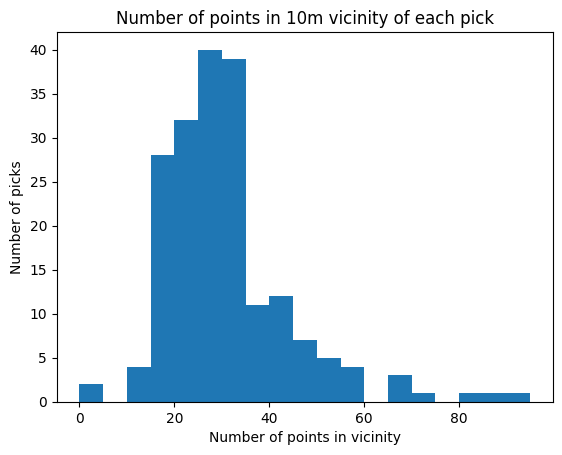

In [1699]:
# make histogram of num points in vicinity of each pick
num_points_in_vicinity = []
for pick_point in picks.geometry:
    nearby_points = points_within_limit(pick_point, trajectory, limit)
    num_points_in_vicinity.append(len(nearby_points))

plt.hist(num_points_in_vicinity, bins=range(0, 100, 5))
plt.xlabel('Number of points in vicinity')
plt.ylabel('Number of picks')
plt.title('Number of points in 10m vicinity of each pick')
plt.show()


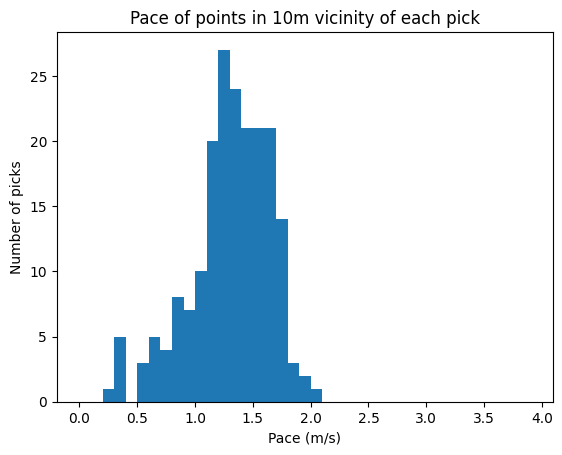

In [1700]:
# find pace of points in vicinity of each pick
pace_in_vicinity = []
for pick_point in picks.geometry:
    nearby_points = points_within_limit(pick_point, trajectory, limit)
    pace_in_vicinity.append(pd.to_numeric(nearby_points['speed']).mean())


plt.hist(pace_in_vicinity, bins=np.arange(0,4,.1))
plt.xlabel('Pace (m/s)')
plt.ylabel('Number of picks')
plt.title('Pace of points in 10m vicinity of each pick')
plt.show()


1.2898965575086143


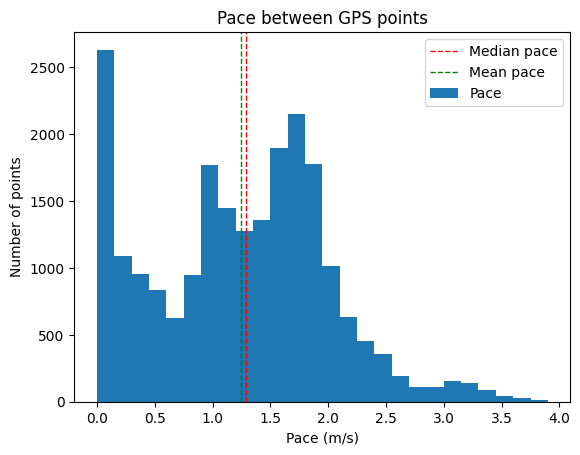

In [1701]:
# create hist of pace num of picks all picks
pace = pd.to_numeric(trajectory['speed']).median()
print(pace)

plt.hist(pd.to_numeric(trajectory['speed']), bins=np.arange(0,4,.15))
plt.axvline(trajectory['speed'].median(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(trajectory['speed'].mean(), color='g', linestyle='dashed', linewidth=1)
plt.xlabel('Pace (m/s)')
plt.ylabel('Number of points')
plt.title('Pace between GPS points')
plt.legend(['Median pace', 'Mean pace', 'Pace'])
plt.show()


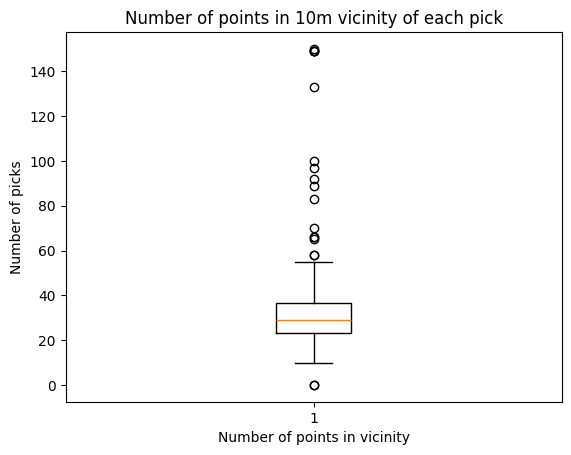

In [1702]:
plt.boxplot(num_points_in_vicinity)
plt.xlabel('Number of points in vicinity')
plt.ylabel('Number of picks')
plt.title('Number of points in 10m vicinity of each pick')
plt.show()

In [1703]:
outliers = detect_outliers(num_points_in_vicinity)

In [1704]:
print(f'Outliers in number of points in vicinity: {detect_outliers(num_points_in_vicinity)}')
print(f'amount of outliers: {len(outliers)}')

Outliers in number of points in vicinity: {1: 70, 13: 89, 14: 92, 59: 133, 117: 58, 120: 83, 148: 100, 155: 149, 156: 149, 157: 149, 158: 149, 159: 150, 171: 66, 190: 97, 193: 66, 194: 58, 195: 65}
amount of outliers: 17


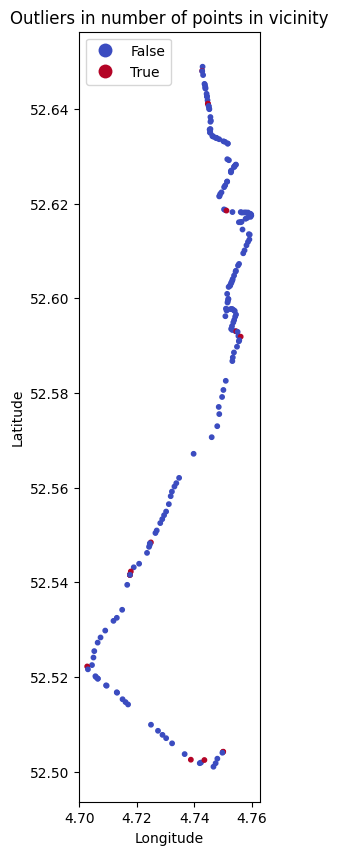

In [1705]:
# add outlier column to picks
picks['outlier'] = False

for i in outliers:
    picks.at[i, 'outlier'] = True

# plot the outliers
picks.plot(column='outlier', legend=True, cmap='coolwarm', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Outliers in number of points in vicinity')
plt.show()


#### 6. Overlapping time-frames

In [1706]:
# Initialize the 'overlapping' column to False
picks['overlapping'] = False

# Iterate through the picks DataFrame and check for overlaps using iloc
for i in range(len(picks)):
    current = picks.iloc[i]
    previous = picks.iloc[i-1] if i > 0 else None
    next = picks.iloc[i+1] if i < len(picks)-1 else None
    
    if overlaps(current, previous, next):
        picks.at[i, 'overlapping'] = True


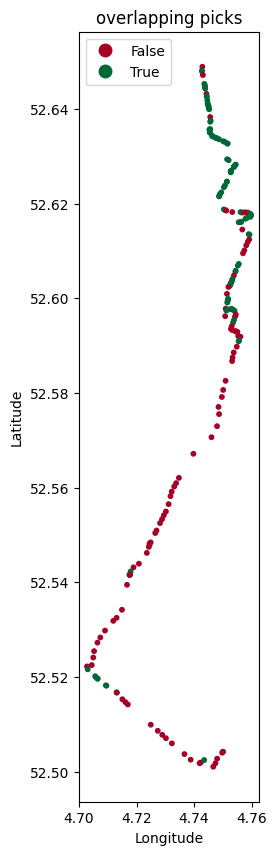

In [1707]:
# plot the non-overlapping picks
picks.plot(column='overlapping', legend=True, cmap='RdYlGn', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('overlapping picks')
plt.show()


In [1708]:
# print min time and max time of last 10 picks
print(picks[['min_time', 'max_time', 'overlapping']].head(10))

             min_time            max_time  overlapping
0 2023-08-19 10:12:11 2023-08-19 10:12:51        False
1 2023-08-19 10:13:50 2023-08-19 10:14:30         True
2 2023-08-19 10:13:59 2023-08-19 10:14:39         True
3 2023-08-19 10:15:44 2023-08-19 10:16:24        False
4 2023-08-19 10:17:59 2023-08-19 10:18:39         True
5 2023-08-19 10:18:15 2023-08-19 10:18:55         True
6 2023-08-19 10:18:54 2023-08-19 10:19:34         True
7 2023-08-19 10:19:19 2023-08-19 10:19:59         True
8 2023-08-19 10:19:29 2023-08-19 10:20:09         True
9 2023-08-19 10:21:00 2023-08-19 10:21:40        False


In [1709]:
from datetime import datetime



# Calculate the percentage overlap for each pick
for i in range(len(picks)):
    current = picks.iloc[i]
    previous = picks.iloc[i-1] if i > 0 else None
    next = picks.iloc[i+1] if i < len(picks)-1 else None
    
    picks.loc[i, 'percentage_overlap'] = percentage_overlap(current, previous, next, timeframe)

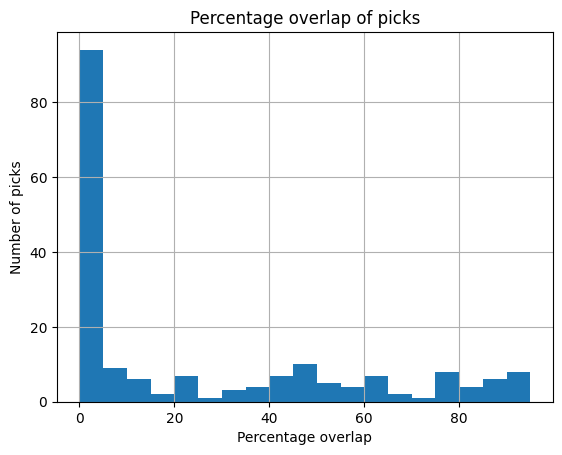

In [1710]:
picks['percentage_overlap'].hist(bins=range(0, 100, 5))
plt.xlabel('Percentage overlap')
plt.ylabel('Number of picks')
plt.title('Percentage overlap of picks')
plt.show()


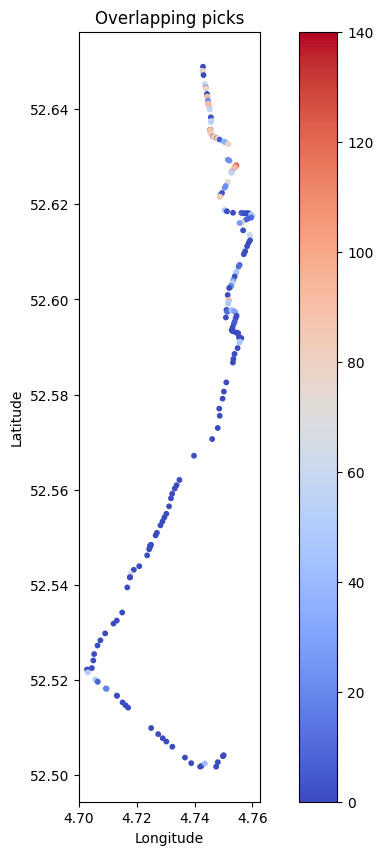

In [1711]:
# plot the overlapping picks
picks.plot(column='percentage_overlap', legend=True, cmap='coolwarm', markersize=10, figsize=(10, 10))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Overlapping picks')
plt.show()


In [1712]:
print(f'Number of picks with less than 50% overlap: {len(picks[(picks["percentage_overlap"] < 50) & (picks["percentage_overlap"] > 0)])}')
print(f'Number of picks with 0% overlap: {len(picks[picks["percentage_overlap"] == 0])}')
print(f'Number of picks with 100% overlap: {len(picks[picks["percentage_overlap"] >= 100])}')

Number of picks with less than 50% overlap: 51
Number of picks with 0% overlap: 92
Number of picks with 100% overlap: 9


#### 7. Results

In [1713]:
# remove outliers from non-overlapping picks
non_overlapping_picks = picks[picks['overlapping'] == False]
non_overlapping_picks = non_overlapping_picks[non_overlapping_picks['outlier'] == False]

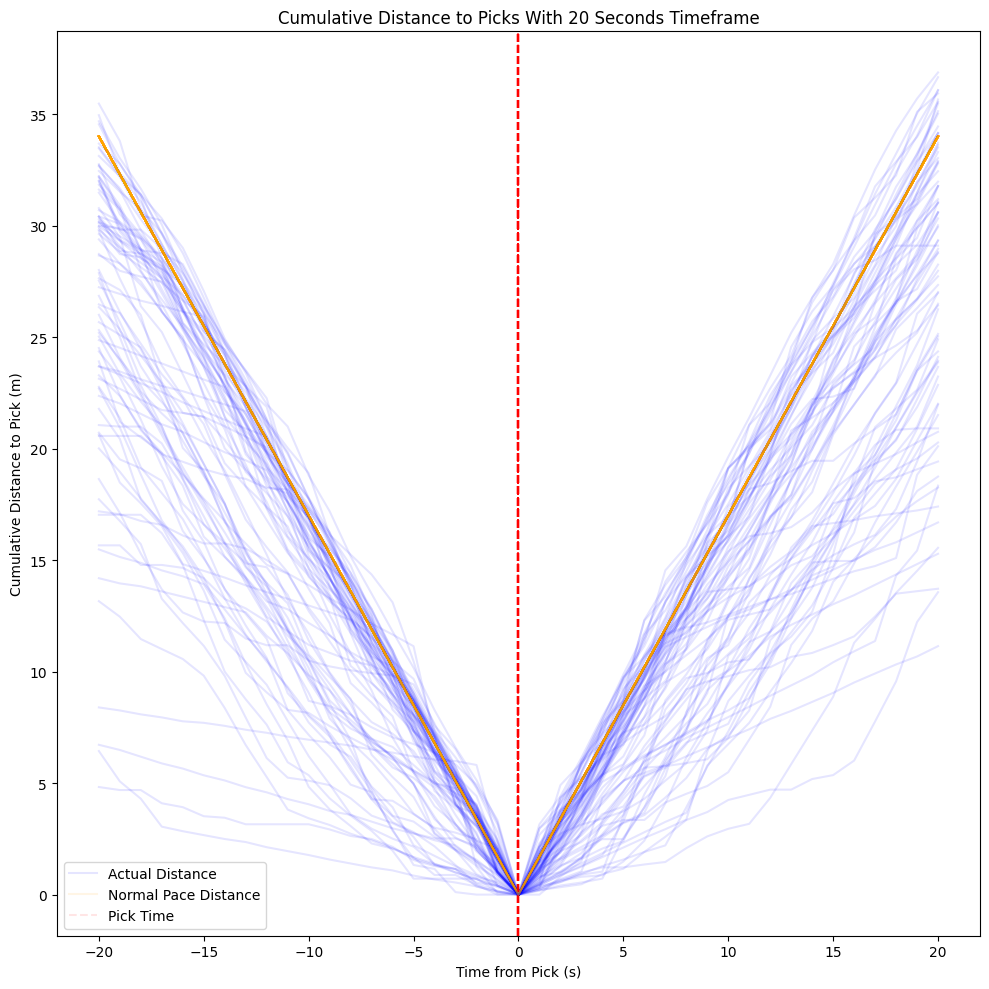

In [1787]:
plot_all_cumulative_distance_pick(non_overlapping_picks, trajectory, timeframe)

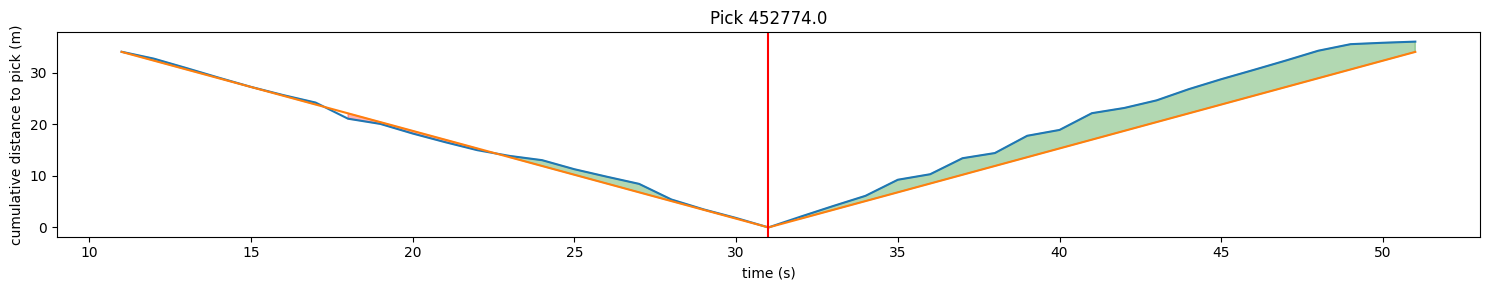

In [1720]:
pick = non_overlapping_picks.iloc[0]
plot_cumulative_distance_pick(pick, trajectory)

In [1721]:
#plot_cumulative_distance_df(non_overlapping_picks, trajectory)

In [1722]:
#plot_acceleration(non_overlapping_picks, trajectory)

In [1723]:
# picks = calculate_extra_time(picks, trajectory, normal_pace)
non_overlapping_picks = calculate_extra_time(non_overlapping_picks, trajectory, normal_pace)

In [1750]:
# count the number of non-overlapping picks per category table format
category_counts = picks['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
print(category_counts)
total = category_counts['count'].sum()
print(f'Total number of the picks: {total}')

            category  count
0        other_waste     57
1     food_packaging     57
2  general_packaging     32
3    cigarette_waste     31
4      recycle_waste     22
Total number of the picks: 199


In [1845]:
# count the number of non-overlapping picks per category table format
category_counts = non_overlapping_picks['category'].value_counts().reset_index()
category_counts.columns = ['category', 'count']
print(category_counts)
total = category_counts['count'].sum()
print(f'Total number of non-overlapping picks: {total}')




            category  count
0     food_packaging     28
1        other_waste     19
2  general_packaging     14
3      recycle_waste     12
4    cigarette_waste      7
Total number of non-overlapping picks: 80


In [1752]:
location_counts = picks['location'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
print(location_counts)
total = location_counts['count'].sum()
print(f'Total number of picks: {total}')

                location  count
0  neighborhood_sidewalk    118
1   dense_urban_sidewalk     40
2           country_side     27
3                   park     14
Total number of picks: 199


In [1753]:
location_counts = non_overlapping_picks['location'].value_counts().reset_index()
location_counts.columns = ['location', 'count']
print(location_counts)
total = location_counts['count'].sum()
print(f'Total number of non-overlapping picks: {total}')


                location  count
0  neighborhood_sidewalk     50
1           country_side     21
2                   park      5
3   dense_urban_sidewalk      4
Total number of non-overlapping picks: 80


In [1743]:
non_overlapping_picks['extra_time'].describe()

count    80.000000
mean      8.413449
std       6.133830
min       0.162087
25%       3.578223
50%       7.025284
75%      11.744717
max      23.236655
Name: extra_time, dtype: float64

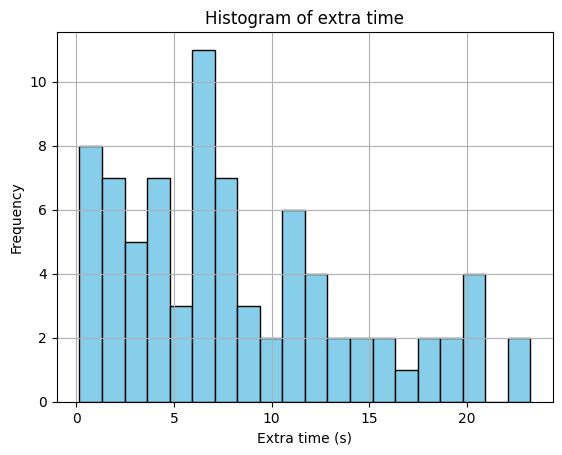

In [1725]:
# Plot a histogram of the extra time
non_overlapping_picks['extra_time'].hist(bins=20, color='skyblue', edgecolor='black', linewidth=1)
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.title('Histogram of extra time')
plt.show()



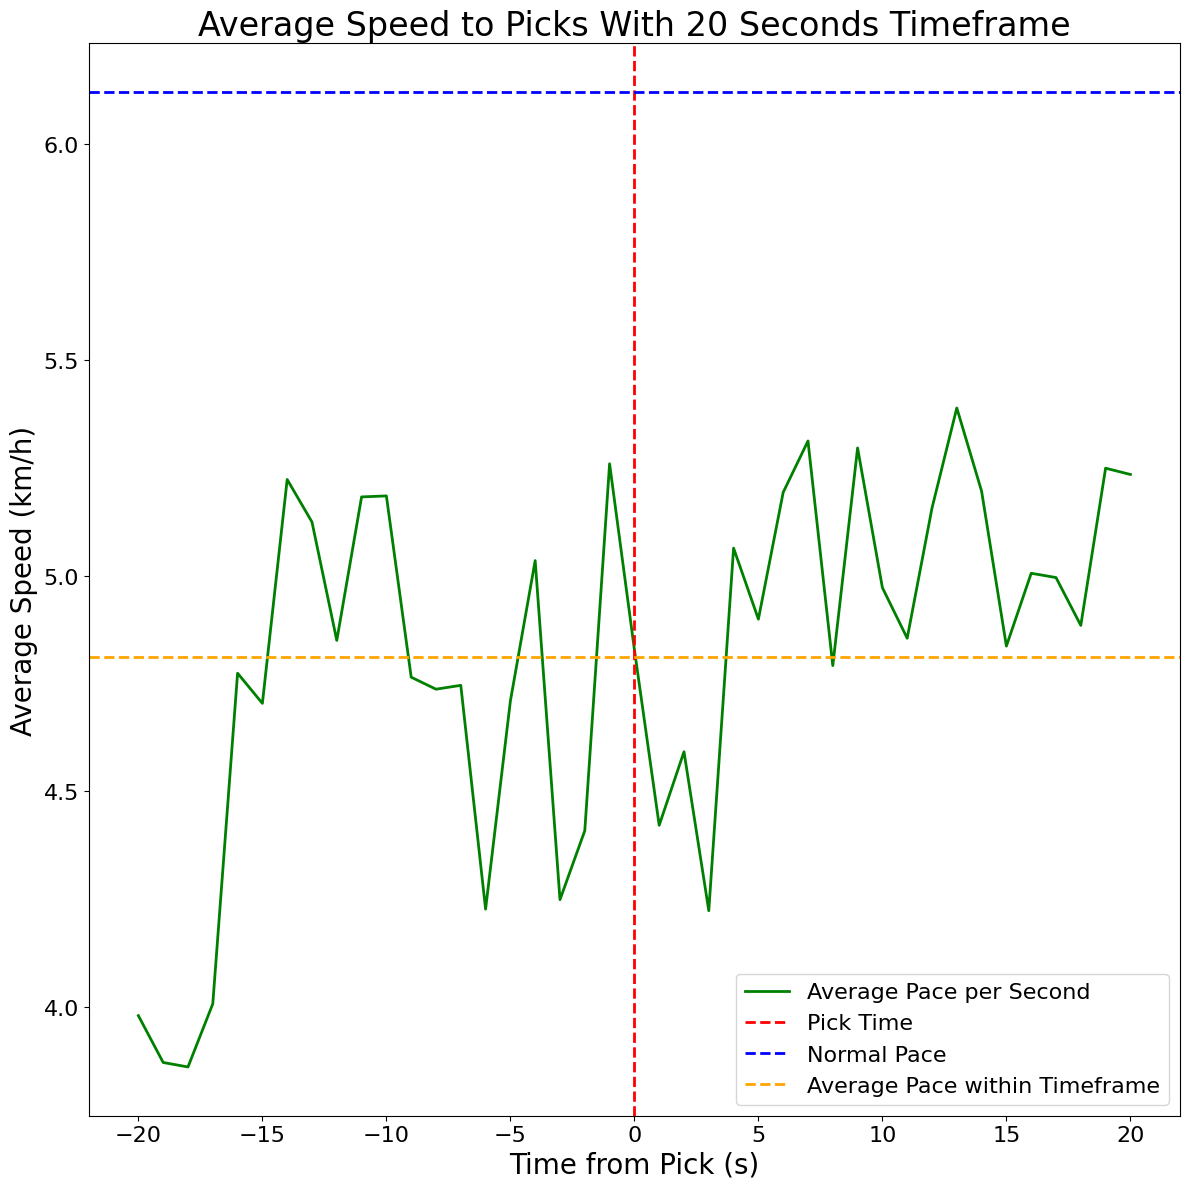

In [1843]:


# Example call to the function with non_overlapping_picks, trajectory, and timeframe variables
plot_average_pace(non_overlapping_picks, trajectory, timeframe, normal_pace)



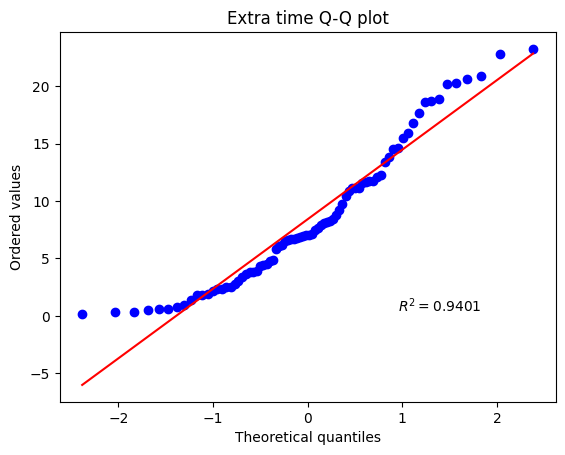

In [1754]:
# QQ plot of extra time
import scipy.stats as stats
stats.probplot(non_overlapping_picks['extra_time'], dist="norm", plot=plt, rvalue=True)
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered values')
plt.title('Extra time Q-Q plot')
plt.show()


In [1799]:
norm_results = calculate_distribution_statistics(non_overlapping_picks['extra_time'])

log_norm_results = calculate_lognormal_distribution_statistics(non_overlapping_picks['extra_time'])


Mean: 8.413449344499638
Standard Deviation: 6.09537312431811
Skewness: 0.6828195312053001
Kurtosis: -0.42596834369619785


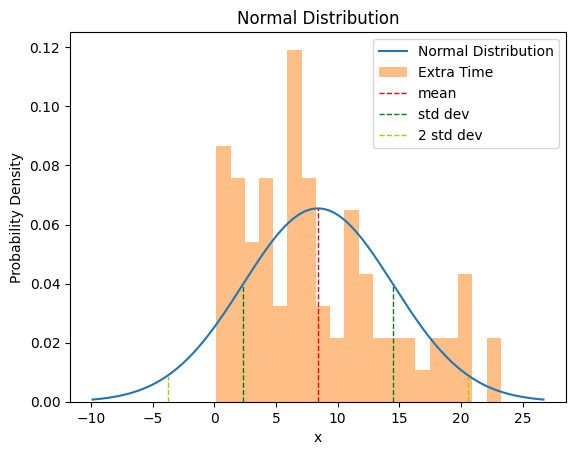

In [1826]:
print(f"Mean: {norm_results['mean']}")
print(f"Standard Deviation: {norm_results['standard_deviation']}")
print(f"Skewness: {norm_results['skewness']}")
print(f"Kurtosis: {norm_results['kurtosis']}")


# Plot the normal distribution
plt.plot(norm_results['x_values'], norm_results['pdf_values'], label='Normal Distribution')

# Plot the histogram
plt.hist(non_overlapping_picks['extra_time'], bins=20, density=True, alpha=0.5, label='Extra Time')

# Calculate the y-values of the normal distribution at the x-values where the vertical lines are drawn
y_mean = stats.norm.pdf(norm_results['mean'], norm_results['mean'], norm_results['standard_deviation'])
y_std1 = stats.norm.pdf(norm_results['mean'] + norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
y_std2 = stats.norm.pdf(norm_results['mean'] - norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
y_std3 = stats.norm.pdf(norm_results['mean'] + 2*norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])
y_std4 = stats.norm.pdf(norm_results['mean'] - 2*norm_results['standard_deviation'], norm_results['mean'], norm_results['standard_deviation'])

# Draw the vertical lines
plt.vlines(norm_results['mean'], 0, y_mean, color='r', linestyle='dashed', linewidth=1, label='mean')
plt.vlines(norm_results['mean'] + norm_results['standard_deviation'], 0, y_std1, color='g', linestyle='dashed', linewidth=1, label='std dev')
plt.vlines(norm_results['mean'] - norm_results['standard_deviation'], 0, y_std2, color='g', linestyle='dashed', linewidth=1)
plt.vlines(norm_results['mean'] + 2*norm_results['standard_deviation'], 0, y_std3, color='y', linestyle='dashed', linewidth=1, label='2 std dev')
plt.vlines(norm_results['mean'] - 2*norm_results['standard_deviation'], 0, y_std4, color='y', linestyle='dashed', linewidth=1)

# Add labels and legend
plt.title('Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()


In [1744]:
# use statistical test to check normality of extra time
stat, p = shapiro(non_overlapping_picks['extra_time'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')

else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.933, p=0.000
Sample does not look Gaussian (reject H0)


Log-Transformed Mean: 1.7317885997029605
Log-Transformed Standard Deviation: 1.0743742197096424
Log-Transformed Skewness: -1.1642826246912827
Log-Transformed Kurtosis: 1.0425862826241268


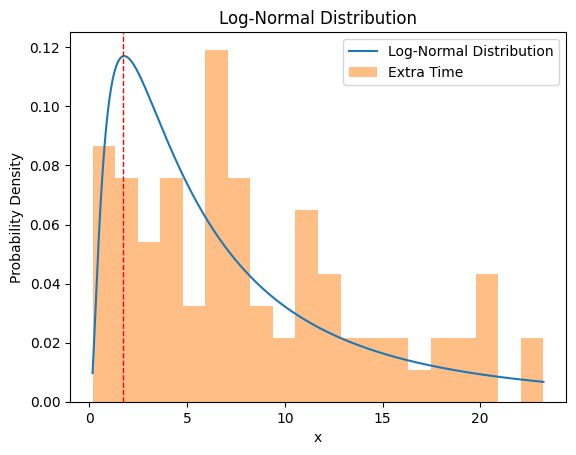

In [1728]:

print(f"Log-Transformed Mean: {norm_results['mean_log']}")
print(f"Log-Transformed Standard Deviation: {norm_results['std_dev_log']}")
print(f"Log-Transformed Skewness: {norm_results['skewness_log']}")
print(f"Log-Transformed Kurtosis: {norm_results['kurtosis_log']}")

# Plot the log-normal distribution
plt.plot(norm_results['x_values'], norm_results['pdf_values'], label='Log-Normal Distribution')
plt.hist(non_overlapping_picks['extra_time'], bins=20, density=True, alpha=0.5, label='Extra Time')
plt.axvline(norm_results['mean_log'], color='r', linestyle='dashed', linewidth=1)
plt.title('Log-Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


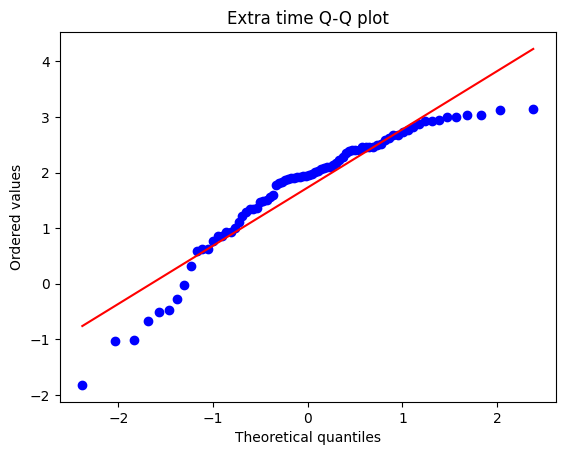

In [1749]:
# q plot of log normal distribution
stats.probplot(np.log(non_overlapping_picks['extra_time']), dist="norm", plot=plt)
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered values')
plt.title('Extra time Q-Q plot')
plt.show()


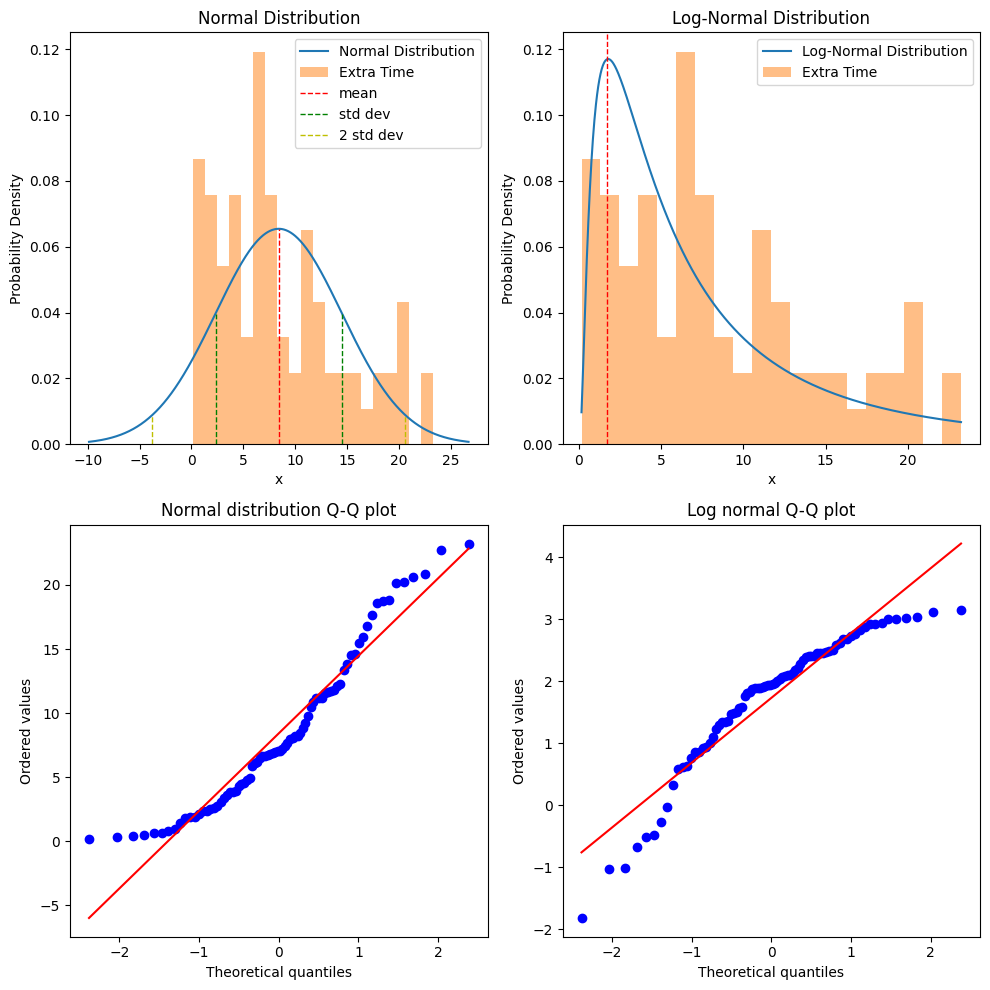

In [1815]:
plot_distributions(non_overlapping_picks, norm_results, log_norm_results)


In [1745]:
# Perform the Shapiro-Wilk test
stat, p = shapiro(np.log(non_overlapping_picks['extra_time']))
print('Statistics=%.3f, p=%.3f' % (stat, p))

# Interpret the results
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')

else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.902, p=0.000
Sample does not look Gaussian (reject H0)


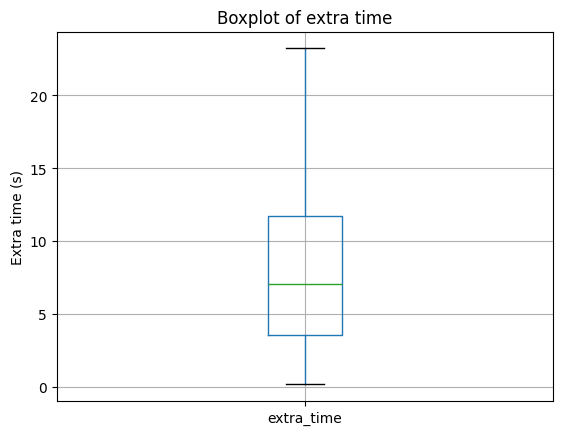

In [1746]:
# make a boxplot of the extra time
non_overlapping_picks.boxplot(column='extra_time')
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time')
plt.show()


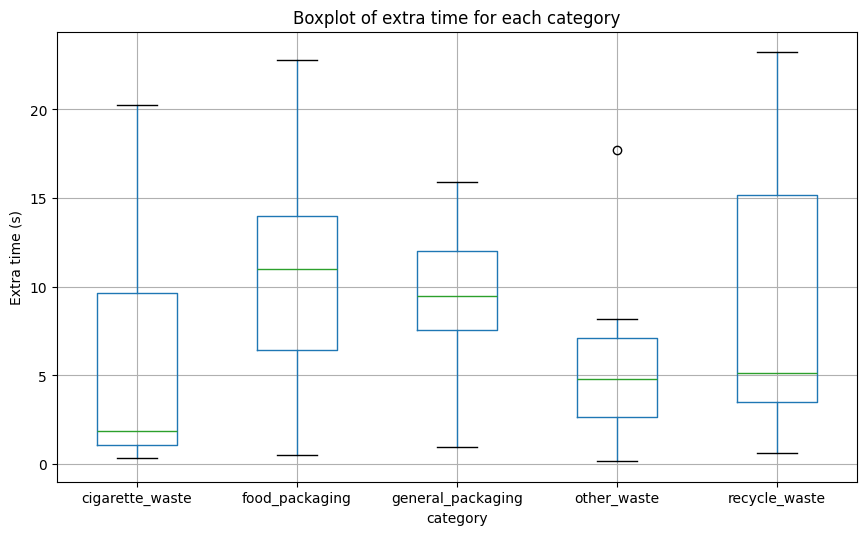

In [1732]:
# Plot a boxplot of the extra time for each category
non_overlapping_picks.boxplot(column='extra_time', by='category', figsize=(10, 6))
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time for each category')
plt.suptitle('')
plt.show()


In [1823]:
alpha = 0.05
# check normality of extra time for each category
for category in non_overlapping_picks['category'].unique():
    data = non_overlapping_picks[non_overlapping_picks['category'] == category]['extra_time']
    stat, p = shapiro(data)
    print(f'{category}: Statistics={stat}, p={p}')
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

cigarette_waste: Statistics=0.8180292720061378, p=0.06146878862740764
Sample looks Gaussian (fail to reject H0)
other_waste: Statistics=0.8627102929929216, p=0.010876437005098848
Sample does not look Gaussian (reject H0)
food_packaging: Statistics=0.9607476903273353, p=0.36314910827052704
Sample looks Gaussian (fail to reject H0)
general_packaging: Statistics=0.9561276046368983, p=0.6591494024325336
Sample looks Gaussian (fail to reject H0)
recycle_waste: Statistics=0.8194279855254472, p=0.01571443574704797
Sample does not look Gaussian (reject H0)


In [1734]:
# Perform the Kruskal-Wallis test
stat, p = kruskal(*[group['extra_time'] for name, group in non_overlapping_picks.groupby('category')])
alpha = 0.05

print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

if p < alpha:
    print("Reject the null hypothesis: The median extra times are significantly different.")
else:
    print("Fail to reject the null hypothesis: The median extra times are not significantly different.")


Kruskal-Wallis Test Statistic: 10.981461756242481
P-value: 0.026773150579296447
Reject the null hypothesis: The median extra times are significantly different.


In [1854]:
# Perform the Dunn's test
dunn_results = posthoc_dunn(non_overlapping_picks, val_col='extra_time', group_col='category', p_adjust='holm')

# Display the results with two decimals
print(dunn_results.round(2))


                   cigarette_waste  food_packaging  general_packaging  \
cigarette_waste               1.00            0.50               0.62   
food_packaging                0.50            1.00               1.00   
general_packaging             0.62            1.00               1.00   
other_waste                   1.00            0.05               0.15   
recycle_waste                 1.00            1.00               1.00   

                   other_waste  recycle_waste  
cigarette_waste           1.00            1.0  
food_packaging            0.05            1.0  
general_packaging         0.15            1.0  
other_waste               1.00            1.0  
recycle_waste             1.00            1.0  


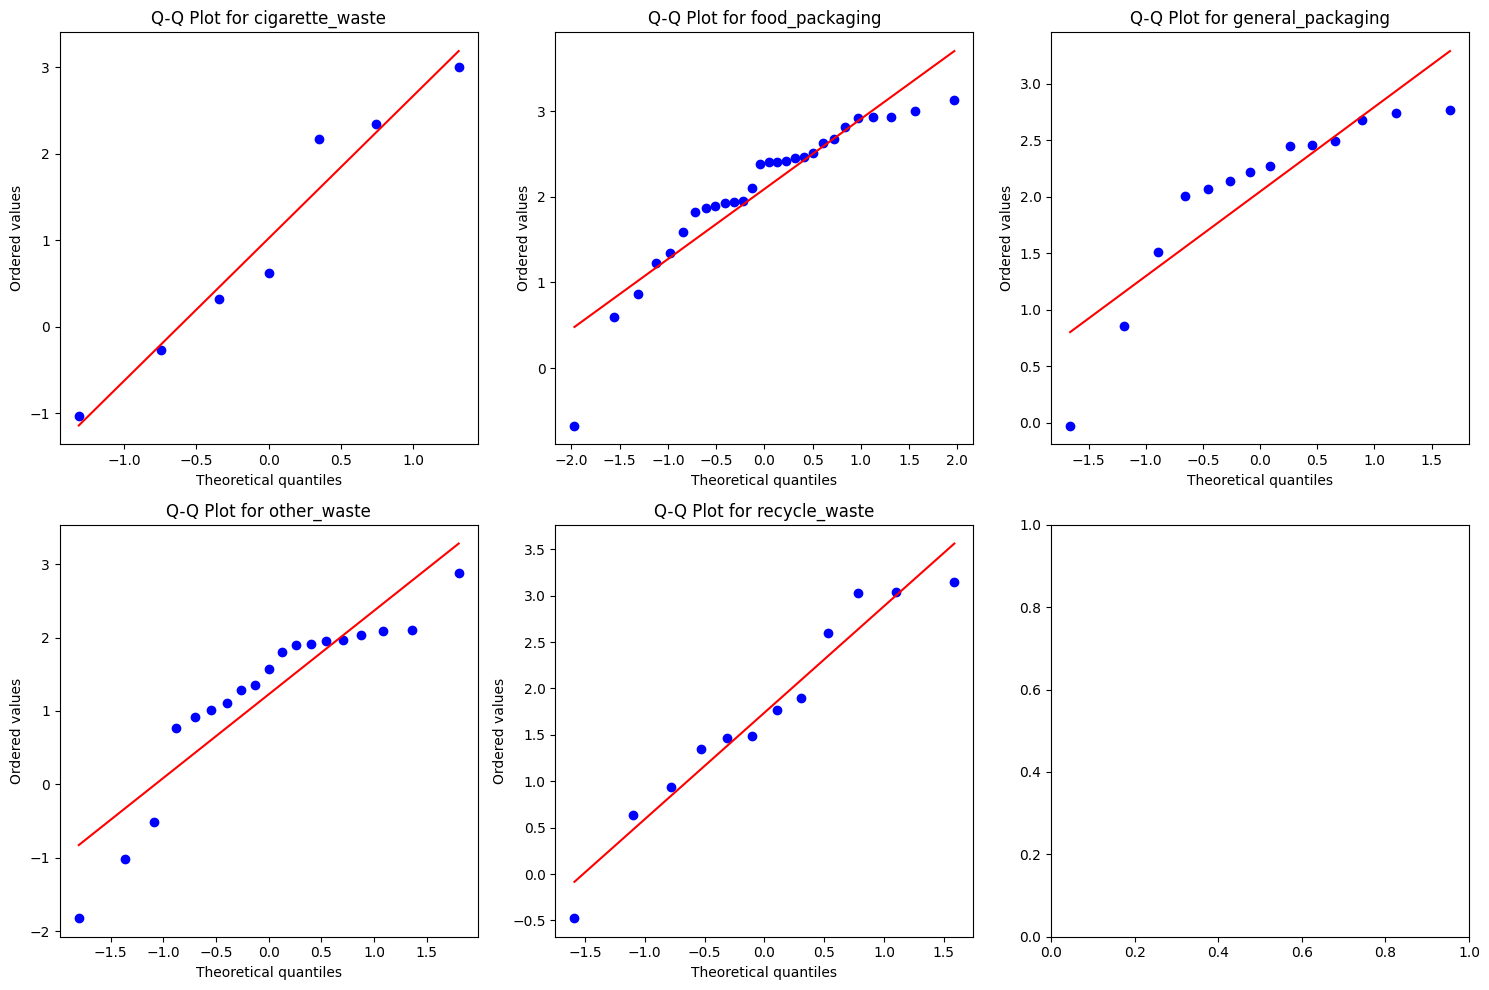

In [1735]:
# q plot of log normal distribution for each category
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (name, group) in enumerate(non_overlapping_picks.groupby('category')):
    stats.probplot(np.log(group['extra_time']), dist="norm", plot=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Q-Q Plot for {name}')
    axs[i//3, i%3].set_xlabel('Theoretical quantiles')
    axs[i//3, i%3].set_ylabel('Ordered values')

plt.tight_layout()
plt.show()

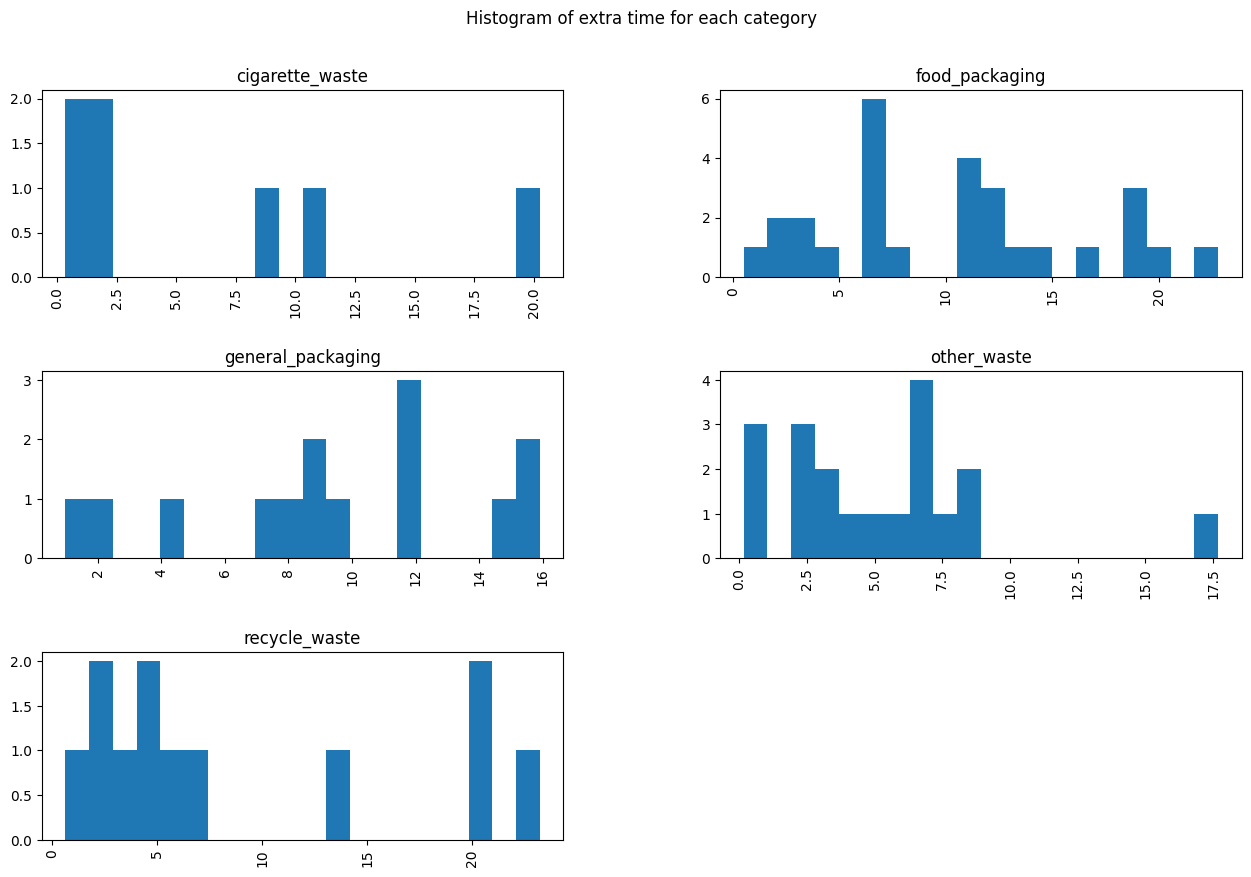

In [1736]:
# histogram of extra time for each category
non_overlapping_picks.hist(column='extra_time', by='category', bins=20, figsize=(15, 10))
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.suptitle('Histogram of extra time for each category')
plt.show()


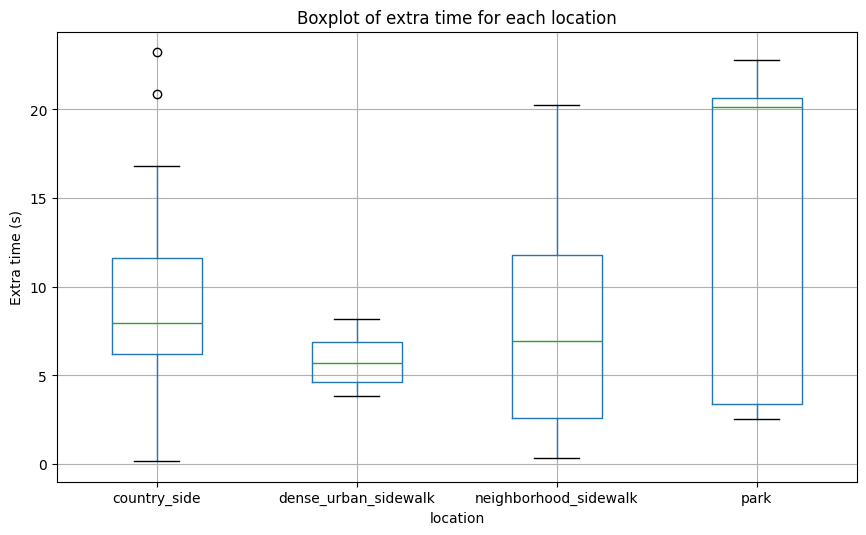

In [1737]:
# Plot a boxplot of the extra time for each location
non_overlapping_picks.boxplot(column='extra_time', by='location', figsize=(10, 6))
plt.ylabel('Extra time (s)')
plt.title('Boxplot of extra time for each location')
plt.suptitle('')
plt.show()


In [1824]:
# check normality of extra time for each location
for location in non_overlapping_picks['location'].unique():
    data = non_overlapping_picks[non_overlapping_picks['location'] == location]['extra_time']
    stat, p = shapiro(data)
    print(f'{location}: Statistics={stat}, p={p}')
    if p > alpha:
        print('Sample looks Gaussian (fail to reject H0)')
    else:
        print('Sample does not look Gaussian (reject H0)')

neighborhood_sidewalk: Statistics=0.9308902251202875, p=0.005972569250641571
Sample does not look Gaussian (reject H0)
dense_urban_sidewalk: Statistics=0.9781419538374044, p=0.8910389905303444
Sample looks Gaussian (fail to reject H0)
park: Statistics=0.7697286868569451, p=0.04486910524355127
Sample does not look Gaussian (reject H0)
country_side: Statistics=0.943392856602414, p=0.2541118729422835
Sample looks Gaussian (fail to reject H0)


In [1739]:
# Perform the Kruskal-Wallis test
stat, p = kruskal(*[group['extra_time'] for name, group in non_overlapping_picks.groupby('location')])
alpha = 0.05

print(f"Kruskal-Wallis Test Statistic: {stat}")
print(f"P-value: {p}")

if p < alpha:
    print("Reject the null hypothesis: The median extra times are significantly different.")
else:
    print("Fail to reject the null hypothesis: The median extra times are not significantly different.")

Kruskal-Wallis Test Statistic: 2.839929453262812
P-value: 0.41696892887710624
Fail to reject the null hypothesis: The median extra times are not significantly different.


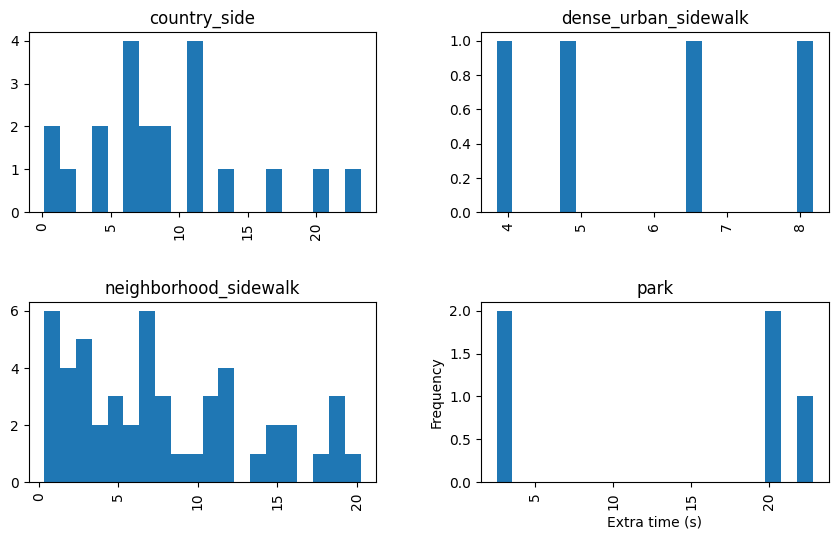

In [1740]:
# histogram of extra time for each location
non_overlapping_picks.hist(column='extra_time', by='location', bins=20, figsize=(10, 6))
plt.xlabel('Extra time (s)')
plt.ylabel('Frequency')
plt.suptitle('')
plt.show()


In [1783]:
# save picks to file in scratch folder
esri_picks = gpd.GeoDataFrame(picks, geometry='geometry')

# make string of datetime columns
esri_picks['min_time'] = esri_picks['min_time'].astype(str)
esri_picks['max_time'] = esri_picks['max_time'].astype(str)
esri_picks['date_taken'] = esri_picks['date_taken'].astype(str)

# set crs to amersfoortse
esri_picks.crs = "EPSG:4326"

esri_picks.to_file('../scratch/picks.shp')

from shapely.geometry import LineString

# Assuming esri_picks is your GeoDataFrame and it has a 'geometry' column with Point geometries
line = LineString(trajectory.geometry.values)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=[line])

# Assign a CRS
gdf.crs = "EPSG:4326"

# save trajectory to file in scratch folder
gdf.to_file('../scratch/trajectory.shp')